## AWS Client Setup
Installa la AWS CLI scaricandola da questo url: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html#getting-started-install-instructions

Una volta installata, incolla le informazioni dalla Command line or programmatic access nella folder .aws nel profilo utente di sistema.

Nel file config
```json
[username]
region = us-west-2
output = json
```

Nel file credential inserire le informazioni in questo formato:

```json
[username]
aws_access_key_id=
aws_secret_access_key=
aws_session_token=
```

In [4]:
import os
from utils import bedrock
from langchain.llms import Bedrock
import pickle


os.environ["AWS_DEFAULT_REGION"] = "us-west-2"  # E.g. "us-east-1"
os.environ["AWS_PROFILE"] = "[fillthis]"

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=True
)

model = Bedrock(
    model_id="anthropic.claude-v2", 
    client=bedrock_runtime,
    model_kwargs={'temperature': 0.8,"max_tokens_to_sample": 1000}
    )

Create new client
  Using region: us-west-2
  Using profile: sky
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)


# Articoli su Attori famosi
Immaginiamo di essere un critico cinematografico che scrive per un blog che ogni giorno raccoglie il compleanno di attori famosi che cadono quel giorno. Prende la sua bio e ne scrive un articolo. Proviamo a velocizzare il suo lavoro!

## Se non volete iscrivervi e settare le API potete saltare questa parte. Ho preparato dei pickle per voi direttamente leggibili dal disco. 

In [2]:
rapid_api_key = ""

Recuperiamo le informazioni attraverso le API di imdb fruibili tramite "RapidAPI"

In [107]:
import requests

def get_bio(name):
    url = "https://imdb8.p.rapidapi.com/actors/get-bio"
    querystring = {"nconst":name}

    headers = {
        "X-RapidAPI-Key": rapid_api_key,
        "X-RapidAPI-Host": "imdb8.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    return response.json()

def get_filmography(name):
    url = "https://imdb8.p.rapidapi.com/actors/get-all-filmography"

    querystring = {"nconst":name}

    headers = {
        "X-RapidAPI-Key": rapid_api_key,
        "X-RapidAPI-Host": "imdb8.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    names = response.json()
    return names
    
def get_born_today(month,day):
    url = "https://imdb8.p.rapidapi.com/actors/list-born-today"
    querystring = {"month":month,"day":day}

    headers = {
        "X-RapidAPI-Key": rapid_api_key,
        "X-RapidAPI-Host": "imdb8.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    list_of_names = response.json()
    names = []
    for name in list_of_names[0:3]:
        r = get_bio(name.split("name/")[1])
        #r = get_filmography(name.split("name/")[1])
        names.append(r)
    return names

In [139]:
month = 7
day = 2
response = get_born_today(month=month,day=day)

In [140]:
'''with open('data/2_7.pickle', 'wb') as handle:
    pickle.dump(response, handle, protocol=pickle.HIGHEST_PROTOCOL)'''

### Se non vuoi agganciare la tua key di RAPID puoi caricare i pickle da qua e continuare

In [5]:
with open('data/2_7.pickle', 'rb') as handle:
    response = pickle.load(handle)

In [6]:
response

[{'@type': 'imdb.api.name.bio',
  'id': '/name/nm3053338/',
  'image': {'height': 1332,
   'id': '/name/nm3053338/images/rm1008443648',
   'url': 'https://m.media-amazon.com/images/M/MV5BMTgxNDcwMzU2Nl5BMl5BanBnXkFtZTcwNDc4NzkzOQ@@._V1_.jpg',
   'width': 1000},
  'legacyNameText': 'Robbie, Margot',
  'name': 'Margot Robbie',
  'birthDate': '1990-07-02',
  'birthPlace': 'Dalby, Queensland, Australia',
  'gender': 'female',
  'heightCentimeters': 167.64,
  'realName': 'Margot Elise Robbie',
  'spouses': [{'current': True,
    'fromDate': '2016-12-18',
    'id': '/name/nm3943537/',
    'name': 'Tom Ackerley'}],
  'trademarks': ['Striking blue eyes', 'Wide smile.'],
  'miniBios': [{'author': 'Pedro Borges',
    'id': '/name/nm3053338/bio/mb0140717',
    'language': 'en',
    'text': "Margot Elise Robbie was born on July 2, 1990 in Dalby, Queensland, Australia to Scottish parents. Her mother, Sarie Kessler, is a physiotherapist, and her father, is Doug Robbie. She comes from a family of fou

## Costruiamo il nostro prompt

In [7]:
from langchain.prompts import (
    ChatPromptTemplate
)
from PIL import Image
import urllib
import matplotlib.pyplot as plt
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

wikipedia_info = wikipedia.run(response[0]['name'])

In [8]:
wikipedia_info

"Page: Margot Robbie\nSummary: Margot Elise Robbie ( MAR-goh ROB-ee; born 2 July 1990) is an Australian actress and producer. Known for her work in both blockbuster and independent films, she has received various accolades, including nominations for three Academy Awards, six BAFTA Awards and four Golden Globe Awards. Time named her one of the 100 most influential people in the world in 2017, and Forbes named her one of the world's highest-paid actresses in 2019.\nBorn and raised in Queensland, Robbie began her career in 2008 on the television series Neighbours, on which she was a regular until 2011. After moving to America, she led the television series Pan Am (2011–2012) and had her breakthrough in 2013 with Martin Scorsese’s black comedy film The Wolf of Wall Street. She achieved wider recognition with starring roles as Jane Porter in The Legend of Tarzan (2016) and Harley Quinn in the DC Extended Universe films, beginning with Suicide Squad (2016).\nRobbie received critical acclaim 

In [9]:
prompt = """"You're a film critic who writes articles about actors whose birthday is today. Use the information provided to write an article in the style indicated."
Actor: {actor}
Nicknames: {nicknames}
Bio: {bio}
gender: {gender}
birth place: {birth_place}
birth data: {birth_date}
Use also this information taken from wikipedia about the actor: 
{wikipedia}
"""

messages = [
            ("system", prompt),
            ("human", "Write a long article that should go on the film critic's blog to celebrate the actor's birthday by remembering him. The article must have a title and a body")
        ]

prompt = ChatPromptTemplate.from_messages(messages=messages)
chain = prompt | model

In [13]:
actor = response[0]['name']
if "nicknames" in response[0]:
    nicknames = ";".join(response[0]['nicknames'])
else:
    nicknames = " Not found"
gender = response[0]['gender']
bio = response[0]['miniBios'][0]['text']
birth_place=response[0]['birthPlace']
birth_date = response[0]['birthDate']

In [14]:
articles = chain.invoke({
    "actor":actor,
    "nicknames":nicknames,
    "bio":bio,
    "gender": gender,
    "birth_place": birth_place,
    "birth_date": birth_date,
    "wikipedia":wikipedia_info
})

 Here is a draft 432 word article celebrating Margot Robbie's birthday:

The Dazzling Margot Robbie Turns 33

Australian actress Margot Robbie celebrates her 33rd birthday today. Best known for her magnetic performances in films like The Wolf of Wall Street, I, Tonya, and Once Upon A Time in Hollywood, Robbie has dazzled audiences with her versatility, commitment, and charisma. 

Born in Queensland, Robbie got her start on the long-running soap opera Neighbours. After moving to America, she landed a lead role on the short-lived series Pan Am. Her big break came in 2013 playing Naomi Lapaglia opposite Leonardo DiCaprio in Martin Scorsese’s The Wolf of Wall Street. Robbie lit up the screen as the fiery, unpredictable trophy wife. Her sexy, scene-stealing performance announced the arrival of a major new talent. 

Robbie went on to earn her first Academy Award nomination for her transformative work as controversial figure skater Tonya Harding in 2017’s I, Tonya. She disappeared into the ro

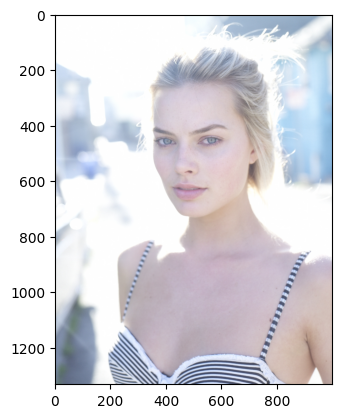

In [15]:
img = Image.open(urllib.request.urlopen(response[0]['image']['url']))
plotimg = plt.imshow(img)

print(articles)

# Scegliamo lo stile, il tono e la lunghezza

In [16]:
tone_and_style_list = ["motivational","inspirational","informative","humorous","casual","serious"]
length_list = ["short","medium","long"]
readability_list = ["easy","intermediate","complex"]


In [17]:
tone = tone_and_style_list[2]
length = length_list[2]
readability = readability_list[2]

tone,length,readability

('informative', 'long', 'complex')

In [18]:
prompt = """"You're an expert Chief Editor that review, correct and rewrite article. Based on the following styles:"
Tone and Style: {tone}
Readability: {readability}
The article must be {length} in length
"""

messages = [
            ("system", prompt),
            ("human", "Review, correct and rewrite the article: {article}")
        ]

prompt = ChatPromptTemplate.from_messages(messages=messages)
chain = prompt | model

In [19]:
chief_articles = chain.invoke({
    "tone":tone,
    "length":length,
    "readability":readability,
    "article": articles
})

In [20]:
print(chief_articles)

 Here is my edited 432 word version of the article celebrating Margot Robbie's 33rd birthday:

Margot Robbie Dazzles at 33 

Australian actress Margot Robbie turns 33 years old today. Robbie has captivated audiences with her versatility, commitment and magnetism in films like The Wolf of Wall Street, I, Tonya, and Once Upon a Time in Hollywood.

Born in Queensland, Robbie got her start on the long-running soap opera Neighbours. After moving to the United States, she landed a lead role on the short-lived series Pan Am. Her big break came in 2013 playing Naomi Lapaglia opposite Leonardo DiCaprio in Martin Scorsese’s The Wolf of Wall Street. Robbie lit up the screen as the fiery, unpredictable trophy wife. Her scene-stealing performance announced the arrival of a bold new talent.

Robbie earned her first Academy Award nomination for her transformative work as controversial figure skater Tonya Harding in 2017’s I, Tonya. She disappeared into the role, showcasing Harding’s ambition, athleti